In [5]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm  # progress bar

# Config
DATA_DIR = 'kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
BATCH_SIZE = 64  # slightly larger batch, faster on GPU
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True  # auto-tune cuDNN for speed

print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
print(f"Using device: {DEVICE}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # make sure it's 3 channels
])

# Load dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print(f"Found classes: {class_names}")

# Split into train & test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

# Faster data loading
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=4, pin_memory=True)

# Define custom CNN
class CancerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, optimizer
model = CancerCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    t0 = time.time()
    
    # progress bar over batches
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss:.4f} - Time: {time.time()-t0:.2f}s "
          f"- GPU mem: {torch.cuda.memory_allocated() / (1024**2):.1f} MB")

print("Training complete.\n")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(DEVICE, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Save model
torch.save(model.state_dict(), "cancer_cnn.pth")
print("\n✅ Model saved as cancer_cnn.pth")


torch.cuda.is_available(): True
Device count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Found classes: ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']
Starting training...


Epoch 1/10: 100%|██████████| 1626/1626 [01:58<00:00, 13.68it/s]


Epoch [1/10] - Loss: 0.7003 - Time: 118.89s - GPU mem: 146.0 MB


Epoch 2/10: 100%|██████████| 1626/1626 [01:57<00:00, 13.78it/s]


Epoch [2/10] - Loss: 0.3248 - Time: 117.97s - GPU mem: 146.0 MB


Epoch 3/10: 100%|██████████| 1626/1626 [01:55<00:00, 14.06it/s]


Epoch [3/10] - Loss: 0.2387 - Time: 115.69s - GPU mem: 146.0 MB


Epoch 4/10: 100%|██████████| 1626/1626 [01:56<00:00, 13.91it/s]


Epoch [4/10] - Loss: 0.1861 - Time: 116.87s - GPU mem: 146.0 MB


Epoch 5/10: 100%|██████████| 1626/1626 [01:57<00:00, 13.89it/s]


Epoch [5/10] - Loss: 0.1547 - Time: 117.05s - GPU mem: 146.0 MB


Epoch 6/10: 100%|██████████| 1626/1626 [01:56<00:00, 13.95it/s]


Epoch [6/10] - Loss: 0.1289 - Time: 116.52s - GPU mem: 146.0 MB


Epoch 7/10: 100%|██████████| 1626/1626 [01:55<00:00, 14.11it/s]


Epoch [7/10] - Loss: 0.1124 - Time: 115.21s - GPU mem: 146.0 MB


Epoch 8/10: 100%|██████████| 1626/1626 [01:56<00:00, 13.95it/s]


Epoch [8/10] - Loss: 0.0996 - Time: 116.56s - GPU mem: 146.0 MB


Epoch 9/10: 100%|██████████| 1626/1626 [01:53<00:00, 14.30it/s]


Epoch [9/10] - Loss: 0.0875 - Time: 113.68s - GPU mem: 146.0 MB


Epoch 10/10: 100%|██████████| 1626/1626 [01:54<00:00, 14.23it/s]


Epoch [10/10] - Loss: 0.0792 - Time: 114.24s - GPU mem: 146.0 MB
Training complete.



Testing: 100%|██████████| 407/407 [00:40<00:00, 10.15it/s]


Classification Report:
                  precision    recall  f1-score   support

      all_benign       0.99      1.00      0.99      1011
       all_early       0.99      0.99      0.99       987
         all_pre       1.00      0.99      0.99      1035
         all_pro       1.00      1.00      1.00       999
    brain_glioma       0.95      0.94      0.94      1055
     brain_menin       0.92      0.88      0.90       976
     brain_tumor       0.91      0.95      0.93       998
   breast_benign       0.93      0.98      0.96       984
breast_malignant       0.96      0.94      0.95       984
      cervix_dyk       0.99      1.00      1.00      1028
      cervix_koc       1.00      0.97      0.99      1019
      cervix_mep       0.98      0.99      0.99      1016
      cervix_pab       1.00      1.00      1.00       973
      cervix_sfi       0.99      1.00      0.99      1003
       colon_aca       0.98      0.98      0.98       942
       colon_bnt       0.99      0.99      0.99

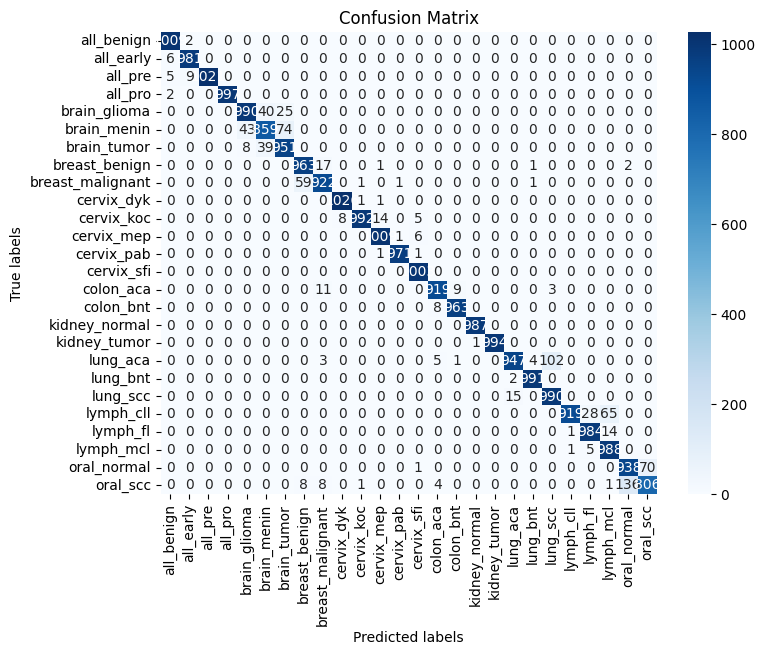

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
